 # Analyzing Trump's Tweets

Donald Trump is famous (or infamous) for for his Tweets. In this notebook, we examine the trends in and nature of Donald Trump's tweets to understand what drives his popularity on twitter. The data for this notebook is sourced from http://www.trumptwitterarchive.com/archive (Alternately, if you have a funtioning Twitter developer's account, you can use the API to import his tweets).

In [2]:
#importing the necessary python libraries 

import os
import pandas as pd
import numpy as np
import datetime as dt

import string
import re 
import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
#nltk.download('stopwords')
#nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer #what's the problem with this vectorizer?
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

import seaborn as sn

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as style
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
plt.style.use('fivethirtyeight')
#setting the resolution for graphs
#mpl.rcParams['figure.dpi']= 300

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


So,first, we import the data, drop the records where any of the columns have an empty (nan) value, reformat the date variable and create some standard datetime features. Notably, a dummy marking the period prior to and after the launch of Donald Trump's political career- marked by the date on which he lauched his presidential campaign (2015-06-16) - is created.

In [3]:
#changing the user directory
os.chdir('C:\\Users\\Cafral\\Desktop\\Trump project')

#importing the data
trump_tweets = pd.read_csv('trump_tweets.txt',sep=",|\n,")

#removing if nan value encountered in any column
trump_tweets = trump_tweets.dropna()

#declaring the date
trump_tweets['date_time'] = trump_tweets['created_at'].apply(lambda x:dt.datetime.strptime(str(x),'%m-%d-%Y %H:%M:%S'))

#sorting by date
trump_tweets = trump_tweets.sort_values(['date_time'])

#date time feature engineering
trump_tweets['date'] = pd.to_datetime(trump_tweets['date_time'].dt.date)
trump_tweets['day'] = trump_tweets['date_time'].dt.day
trump_tweets['dow'] = trump_tweets['date_time'].dt.weekday
trump_tweets['month'] = trump_tweets['date_time'].dt.month
trump_tweets['year'] = trump_tweets['date_time'].dt.year
trump_tweets['hour'] = trump_tweets['date_time'].dt.hour

#election year feature engineering
trump_tweets['PostCampaignLaunchDummy'] = trump_tweets['date_time']>='2015-06-16'

#create variable to tag each tweet
trump_tweets['tweet_tag'] =1

C:\Users\Cafral\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


Then, to guage the popularity of his tweets in a more measurable fashion, the number of retweets and favourites per tweet are categorized into deciles.

In [4]:
#creating deciles for retweets
trump_tweets['retweetDeciles']= pd.qcut(trump_tweets['retweet_count'],10,labels=False)

#creating quintiles for favorites
trump_tweets['favouriteDeciles'] = pd.qcut(trump_tweets['favorite_count'].astype(int),10,labels=False,duplicates='drop')

Lastly, the tweets from sources other than Twitter (excluding the Twitter's related platforms) are deleted.

In [5]:
trump_tweets = trump_tweets.drop(trump_tweets[(trump_tweets['source'] == 'Twitter QandA')\
                                              | (trump_tweets['source'] == 'Periscope')\
                                              | (trump_tweets['source'] == 'Twitter Media Studio')\
                                              |(trump_tweets['source'] == 'Vine - Make a Scene')].index)

#resetting index
trump_tweets = trump_tweets.reset_index()

# The Rise of Donald Trump

First, lets examine when the popularity of Donald Trump - as measured by retweets and favourites on Twitter - started rising. Having divided his tweets in to deciles previously, lets examine when he got more than the median (5th decile) number of retweets and favorites.

C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


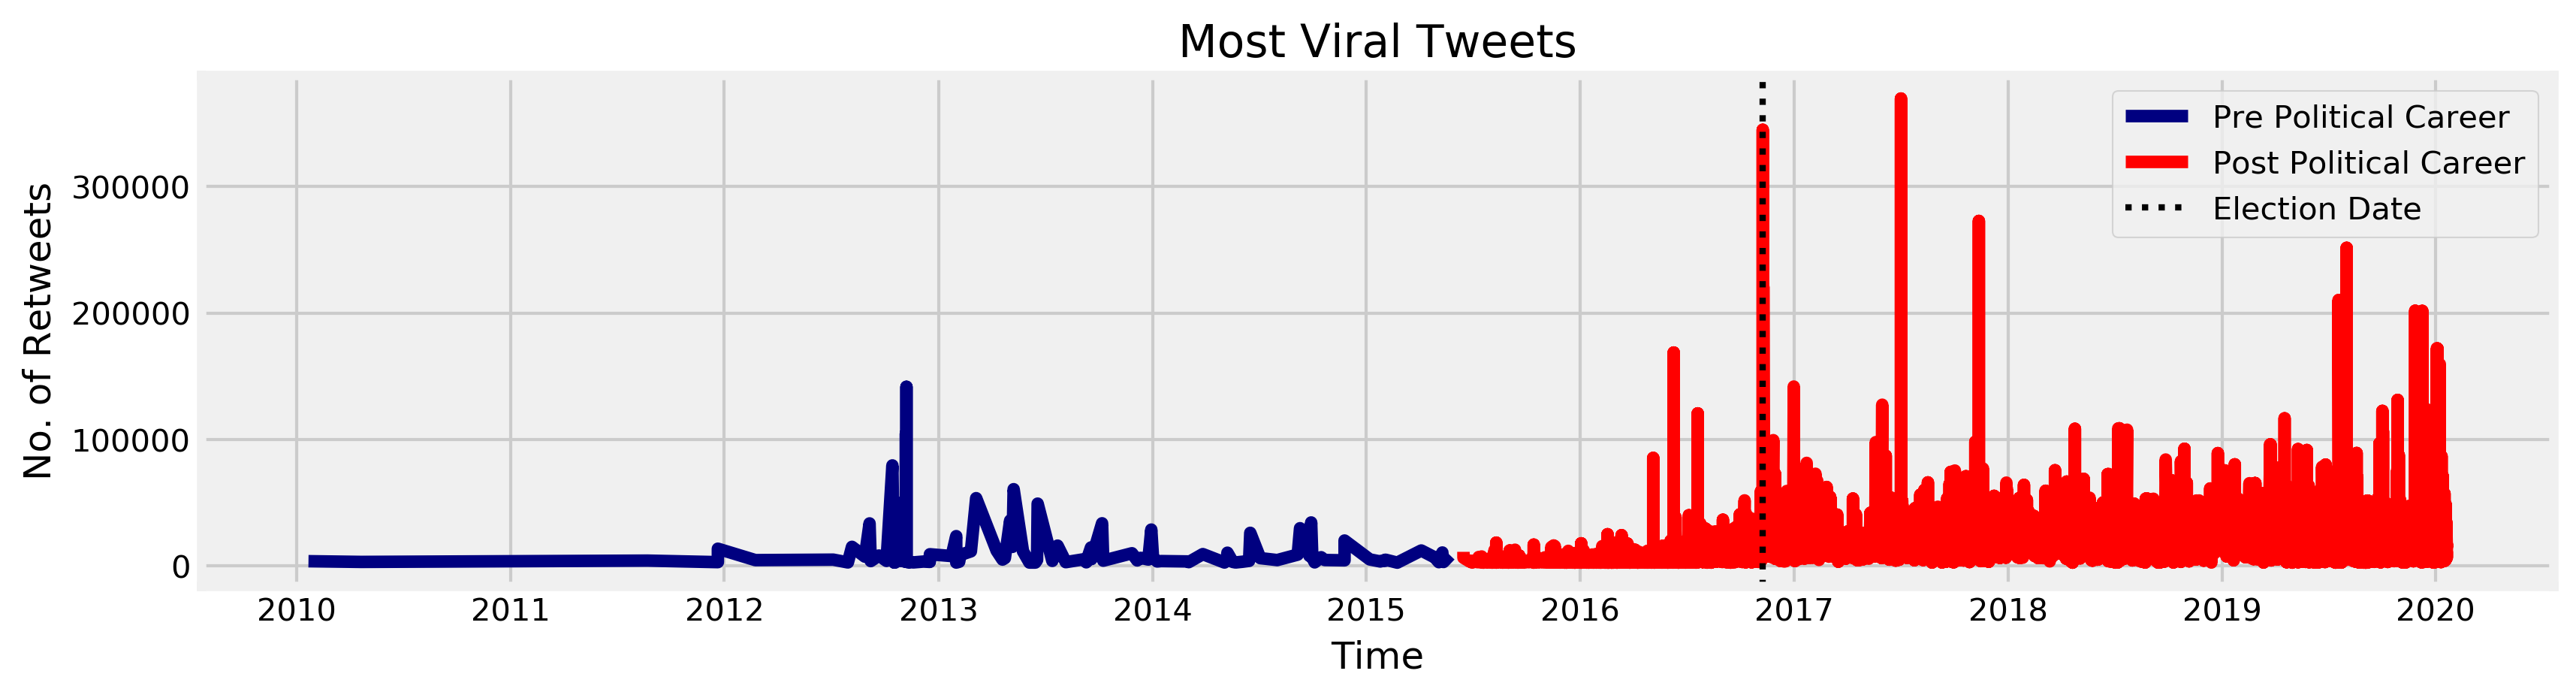

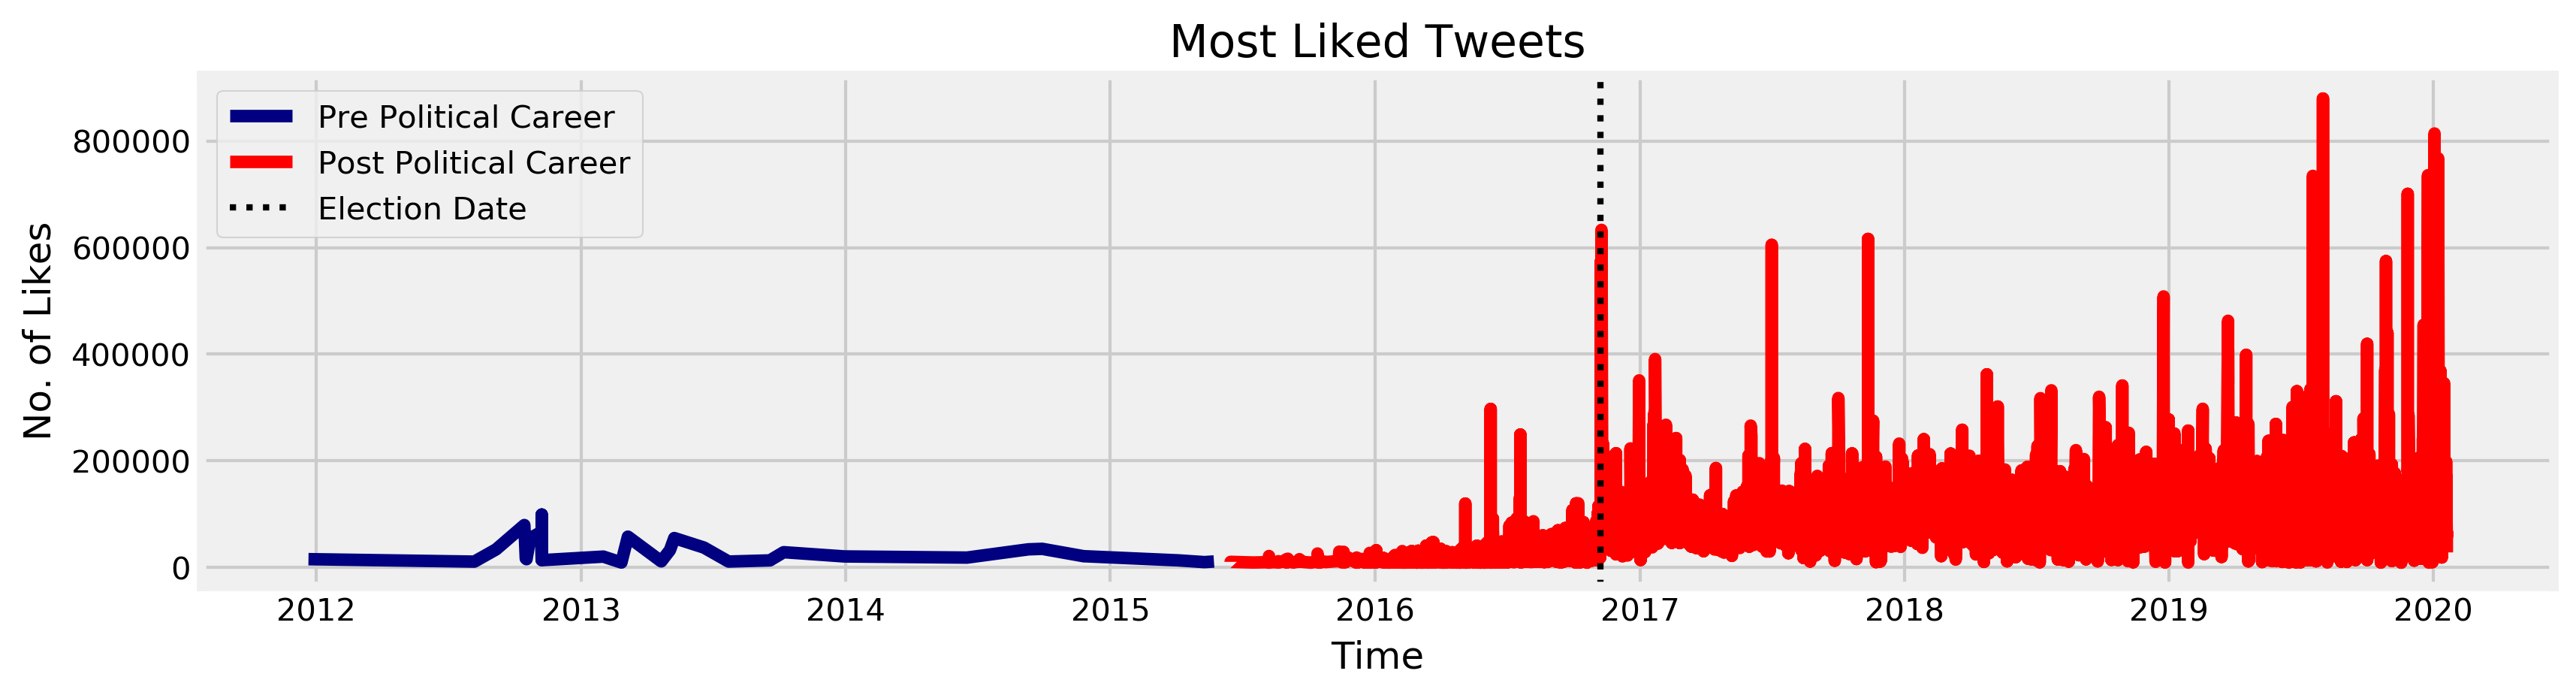

In [6]:
#mpl.rcParams['figure.dpi']= 300
with mpl.rc_context({'figure.dpi': 300}):
    f, ax = plt.subplots(figsize=(12,3))
    plt.plot(trump_tweets['date'][(trump_tweets['retweetDeciles']>5)&(trump_tweets['date']<dt.datetime(2015,6,16))],trump_tweets['retweet_count'][(trump_tweets['retweetDeciles']>5)&(trump_tweets['date']<dt.datetime(2015,6,16))],color='navy')#,color='green',alpha=0.5
    plt.plot(trump_tweets['date'][(trump_tweets['retweetDeciles']>5)&(trump_tweets['date']>=dt.datetime(2015,6,16))],trump_tweets['retweet_count'][(trump_tweets['retweetDeciles']>5)&(trump_tweets['date']>=dt.datetime(2015,6,16))],color='red')#,color='green',alpha=0.5
    plt.title('Most Viral Tweets')
    plt.axvline(dt.datetime(2016, 11,8 ),color="black", linestyle=":",linewidth=2)
    plt.legend(['Pre Political Career','Post Political Career','Election Date'])
    plt.xlabel('Time')
    plt.ylabel('No. of Retweets')
    plt.show()

    f, ax = plt.subplots(figsize=(12,3))
    plt.plot(trump_tweets['date'][(trump_tweets['favouriteDeciles']>5)&(trump_tweets['date']<dt.datetime(2015,6,16))],trump_tweets['favorite_count'][(trump_tweets['favouriteDeciles']>5)&(trump_tweets['date']<dt.datetime(2015,6,16))].astype(int),color='navy')
    plt.plot(trump_tweets['date'][(trump_tweets['favouriteDeciles']>5)&(trump_tweets['date']>=dt.datetime(2015,6,16))],trump_tweets['favorite_count'][(trump_tweets['favouriteDeciles']>5)&(trump_tweets['date']>=dt.datetime(2015,6,16))].astype(int),color='red')
    plt.axvline(dt.datetime(2016, 11,8 ),color="black", linestyle=":",linewidth=2)
    plt.legend(['Pre Political Career','Post Political Career','Election Date'])
    plt.title('Most Liked Tweets')
    plt.xlabel('Time')
    plt.ylabel('No. of Likes')
    plt.show()

Examining the graphs above, it is evident that the interest in his tweets has a small uptick after he announced that he shall be running for president but a clear and consistent uptick after he won the election.  So having established that Donald trump's popularity increased post the launch of his political career and especially after winning the election, let's examine what's driving this uptick.

# So, what's driving his popularity?

One way to increase your popularity is through the sheer force of numbers i.e. increasing one's social media presence by just putting out more content. In this case, that would mean that Donald Trump potentially increased his popularity on Twitter by just tweeting more often. So, let's examine the number of tweets per day by him across his entire life on twitter.

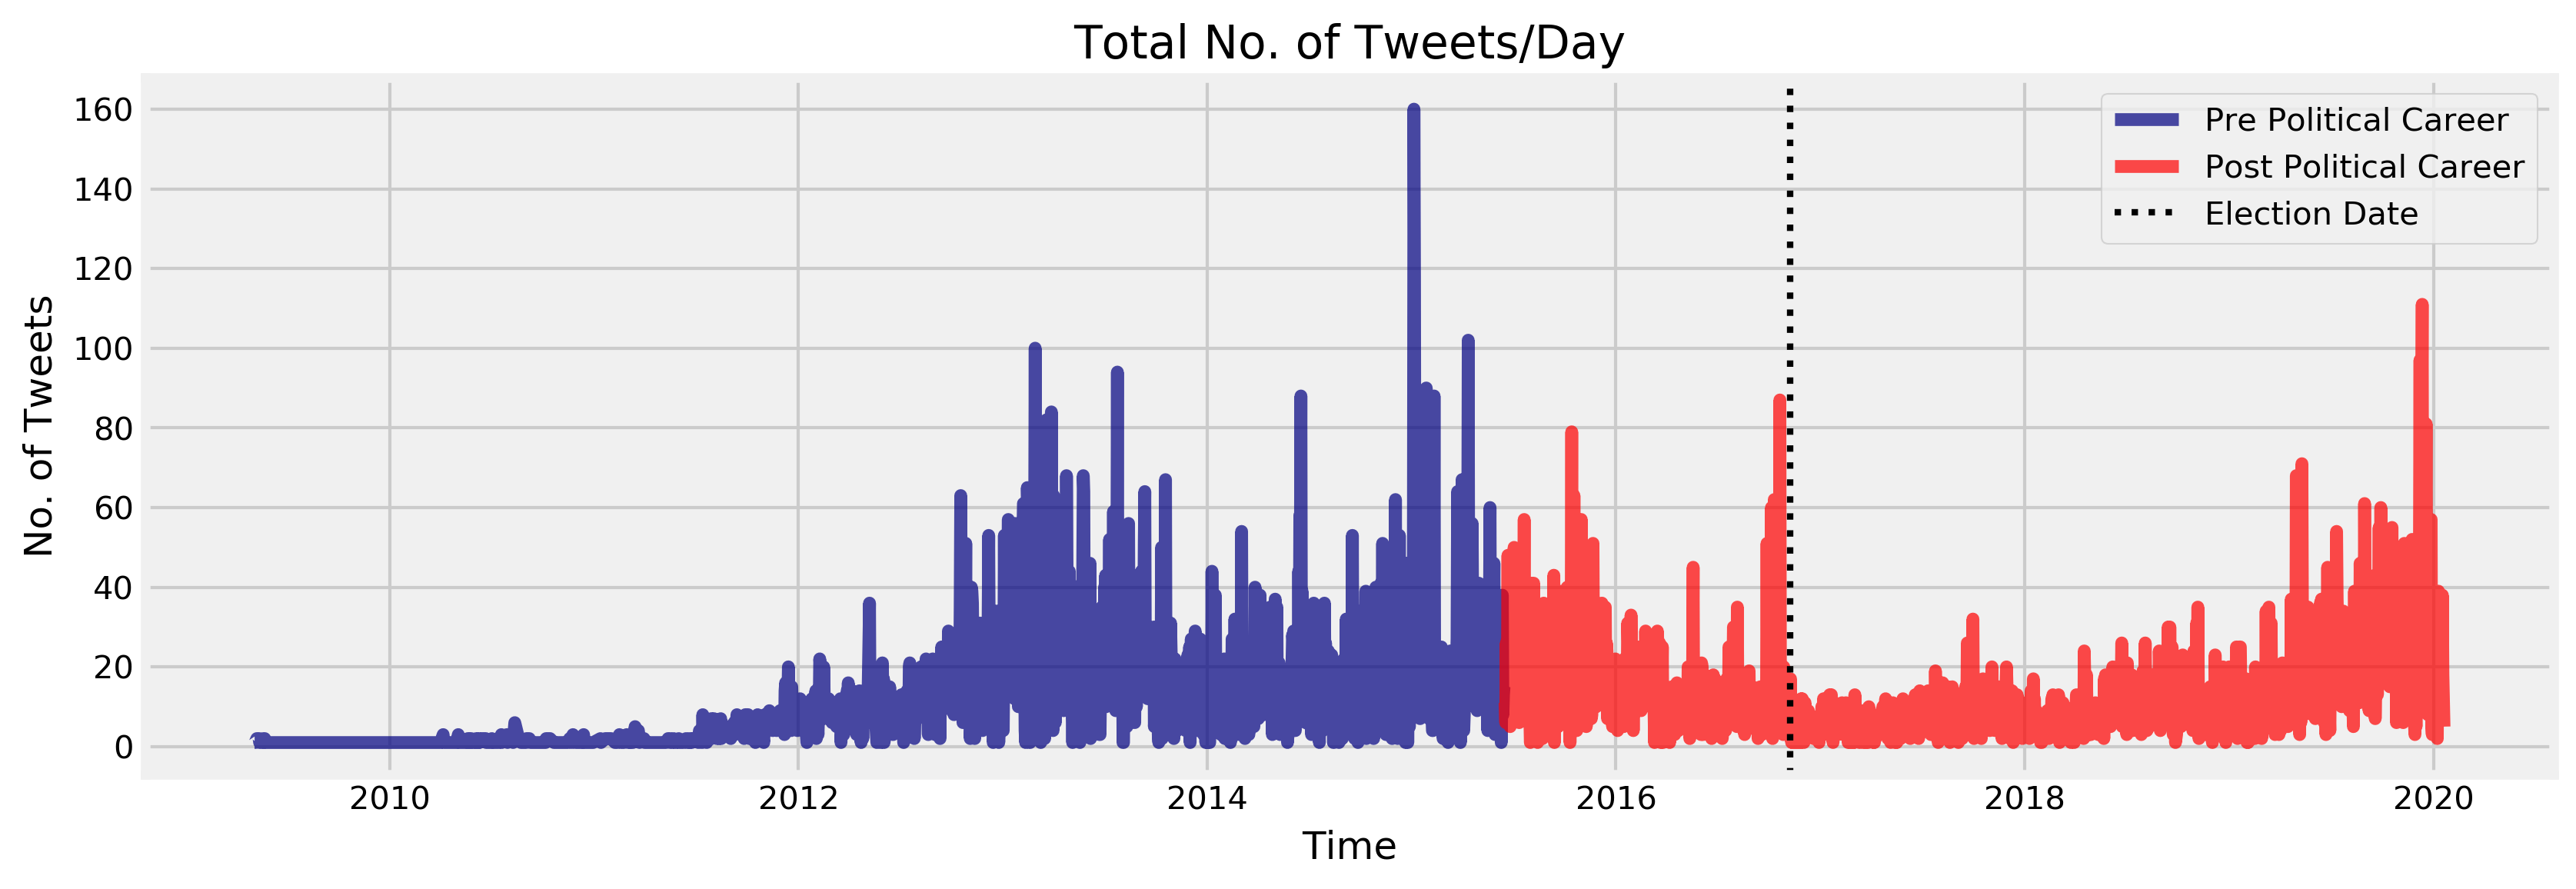

In [7]:
numTweetsPerDayTotal=trump_tweets.groupby(['date'], as_index=False)['tweet_tag','retweet_count','favorite_count'].sum();numTweetsPerDayTotal
with mpl.rc_context({'figure.dpi': 300}):
    f, ax = plt.subplots(figsize=(12,4))
    plt.plot(numTweetsPerDayTotal['date'][pd.to_datetime(numTweetsPerDayTotal['date'])<dt.datetime(2015,6,16)],numTweetsPerDayTotal['tweet_tag'][pd.to_datetime(numTweetsPerDayTotal['date'])<dt.datetime(2015,6,16)],color='navy',alpha=0.7)
    plt.plot(numTweetsPerDayTotal['date'][pd.to_datetime(numTweetsPerDayTotal['date'])>dt.datetime(2015,6,16)],numTweetsPerDayTotal['tweet_tag'][pd.to_datetime(numTweetsPerDayTotal['date'])>dt.datetime(2015,6,16)],color='red',alpha=0.7)
    plt.title('Total No. of Tweets/Day')
    plt.axvline(dt.datetime(2016, 11,8 ),color="black", linestyle=":",linewidth=2)
    plt.legend(['Pre Political Career','Post Political Career','Election Date'])
    plt.ylabel('No. of Tweets')
    plt.xlabel('Time')
    plt.show()

So, the above graph shows that infact, the number of tweets per day has declined (on average) quite drastically since the launch of his political career and especially since he became the president (barring the uptick since 2019). So one can safely conclude that his popularity is not driven by his twitter footprint . 


The next logical avenue for the source of his polularity is the content put out by him- perhaps there has been a shift in the content of his tweets which has resulted in his rising popularity since 2016.

# Analyzing Trump's Tweets

Before analyzing Trump's tweets, it is required that the tweet text be cleaned adequately. First, the text is cleaned in a preliminary fashion. This involves making all the text lower case, removing numbers,punctuations from the text and treating some well known words by making them the same (like different ways of referring to the same country/person).

In [8]:
#removing digits from the text
trump_tweets['text'] = trump_tweets['text'].str.replace('[0-9]','')

#removing punctuation
trump_tweets['text']  = trump_tweets['text'].str.replace('[^\w\s]','')

#lower case
trump_tweets['text'] = trump_tweets['text'].str.lower() ; 

#removing the string 'rt'
trump_tweets['text'] = trump_tweets['text'].str.replace('rt','')

#treating some well known words 
trump_tweets['text'] = trump_tweets['text'].str.replace('barackobama','obama')
trump_tweets['text'] = trump_tweets['text'].str.replace(' barackobama','obama')
trump_tweets['text'] = trump_tweets['text'].str.replace('barackobama ','obama')
trump_tweets['text'] = trump_tweets['text'].str.replace(' barackobama ','obama')

trump_tweets['text'] = trump_tweets['text'].str.replace('realdonaldtrump','trump')
trump_tweets['text'] = trump_tweets['text'].str.replace(' realdonaldtrump','trump')
trump_tweets['text'] = trump_tweets['text'].str.replace('realdonaldtrump ','trump')
trump_tweets['text'] = trump_tweets['text'].str.replace(' realdonaldtrump ','trump')

trump_tweets['text'] = trump_tweets['text'].str.replace('american','america')
trump_tweets['text'] = trump_tweets['text'].str.replace('ukrainian','ukrain')
trump_tweets['text'] = trump_tweets['text'].str.replace('russian','russia')
trump_tweets['text'] = trump_tweets['text'].str.replace('chinese','china')
trump_tweets['text'] = trump_tweets['text'].str.replace('korean','korea')

Next, a function is defined to clean text by removing stop words, non-alphabetic characters,stem characters (i.e. remove -ing,-er,-s etc from words),very short words, links to external pages and in the case of non-machine learning application of the cleaned text, modal verbs.

In [9]:
def clean_text(df,colToClean,ml_option):
    modal_verbs = ['can','couldnt' ,'could','cant', 'may', 'might', 'must','mustnt', 'will', 'would','wouldnt', 'shall', 'should','shouldnt', 'ought', 'had', 'have','need','dare','do','dont']
    stop_words = set(stopwords.words('english'))
    
    df['clean_text'] = df[colToClean].apply(word_tokenize)
    
    if ml_option =='yes':
        
        df['clean_text'] = df['clean_text'].apply(lambda x: [wrd for wrd in x if wrd.isalpha()])
    else:
        #remove modal verbs
        df['clean_text'] = df['clean_text'].apply(lambda x: [wrd for wrd in x if wrd.isalpha()])
        # remove all tokens that are not alphabetic
        df['clean_text'] = df['clean_text'].apply(lambda x: [t for t in x if not t in modal_verbs])
    
    # filter out stop words
    df['clean_text'] = df['clean_text'].apply(lambda x:[w for w in x if not w in stop_words])
    
    #stemming of word  
    porter = PorterStemmer()
    df['clean_text'] = df['clean_text'].apply(lambda x:[porter.stem(word) for word in x])
    
    df['clean_text'] = df['clean_text'].apply(lambda x: [wrds for wrds in x if len(wrds) > 1])
    
    df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word.find("http")== -1])
    
    df['clean_text'] = df['clean_text'].agg(lambda x: ' '.join(x))
    
    return df['clean_text']

## a. Most commonly used words

In [10]:
trump_tweets['noMl_clean_text'] = clean_text(trump_tweets,'text','no')

Next, a function is defined to create a vocabulary of all the unique words in the sample. The function also counts the number of times each unique word occurs in the sample. 

In [11]:
def vocabulary_counter(textToAnalyse):
    vocab = Counter()
    total_words = 0
    for cell in list(textToAnalyse.astype(str)):
        wordCount = 0
        tokens = cell.split()
        vocab.update(tokens)
        wordCount = len(tokens)
        total_words = total_words +int(wordCount)
        
    return vocab,total_words

Having defined the function, the 50 most commonly used words by Trump, pre and post the launch of his political campaign are plotted.

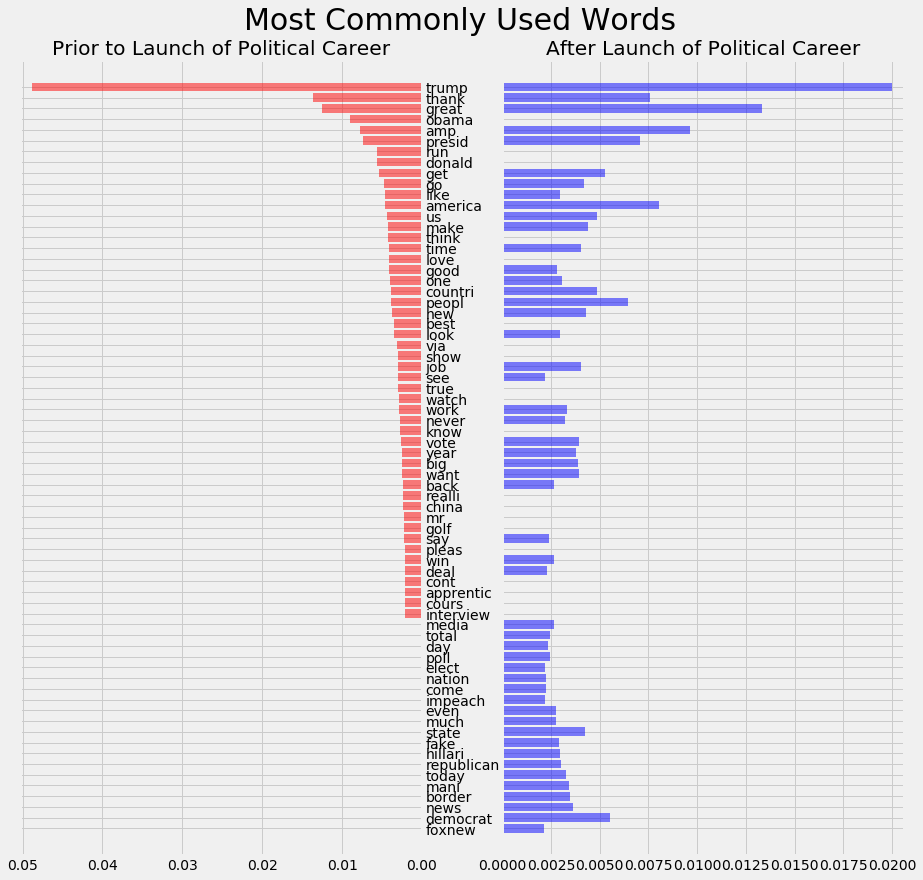

In [12]:

prePolVocab,preTweet_total_words = vocabulary_counter(trump_tweets['noMl_clean_text'][trump_tweets['PostCampaignLaunchDummy']==0])
postPolVocab,postTweet_total_words = vocabulary_counter(trump_tweets['noMl_clean_text'][trump_tweets['PostCampaignLaunchDummy']==1])

#putting the 50 most common words from each period into a pands dataframe
prePolVocabMostCommon = pd.DataFrame(prePolVocab.most_common(50))
prePolVocabMostCommon.columns = ['word','prePolCount']

postPolVocabMostCommon = pd.DataFrame(postPolVocab.most_common(50))
postPolVocabMostCommon.columns = ['word','postPolCount']

#merging the two data frames
polCareer = pd.merge(prePolVocabMostCommon ,postPolVocabMostCommon,on = 'word',how= 'outer' )
polCareer.loc[polCareer['prePolCount'].isna(),'prePolCount'] = 0
polCareer.loc[polCareer['postPolCount'].isna(),'postPolCount'] = 0

#sorting by the words used most commonly prior to the launch of his political career
polCareer = polCareer.sort_values(['prePolCount'])

#plotting the results
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(13,12))

axes[0].barh(polCareer['word'],(polCareer['prePolCount']/preTweet_total_words), align='center',color='red',alpha=0.5)
axes[0].set_title('Prior to Launch of Political Career')
axes[1].barh(polCareer['word'],(polCareer['postPolCount']/postTweet_total_words),align='center',color='blue',alpha=0.5)
axes[1].set_title('After Launch of Political Career')
axes[0].invert_xaxis()
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
fig.suptitle('Most Commonly Used Words',ha = 'center',y=1.02,size = 30)
plt.show()

Analyzing the graph above, we see that there is a perceptible shift in the most commonly used words since the launch of his political career. Prior to the launch of his election, the words used most commonly in his tweets were neutral (like run, think,via,show etc.) and not political - barring barack obama and china. However, since the launch of his political career , the words used most commonly by him have become extremely political - for instance elections, the border wall, fake news , the impeachment, the democrats, Hilary Clinton.  Notably, 3 overtly positive words - love, best and true completely fall out of his most commonly used vocabulary on Twitter. Interstingly, since the launch of his political career, Obama drops from his most frequently used words and Foxnews makes an appearance, further indicating that is interests in political matters have diversified away from Obama.  Thus, we can see that the period associated with him becoming much more popular, is also the period in which his tweets became more political (and thus more controversial) and marginally less positive. Hence, perhaps once he started tweeting more frequently about a larger variety of political matters , his popularity started increasing.

## b. Machine Learning Based Analysis
### b.1 Kmeans clustering

However, it is not sufficent to just tweets about topical political matters to become viral on twitter. It is the associated context or opinion regarding a topic that helps a user gain traction (or not) on Twitter. To establish the opinion/context regarding a particular topic that Donald Trump is tweeting about (in an admittedly rudimentary fashion) , kmeans clustering is used. Kmeans clustering essentially groups similar data points together to make a presecified number ('k') of clusters.

Given the prevailing hypothesis that the nature of his tweets has seen a fundamental shift since the lanch of his political career, Kmeans clustering is not conducted on the whole dataset. First the data is divided into 2 parts:tweets prior to and after the launch of his political career. However, to establish more robustly that his more topical/political tweets get more attention on social media, each time period is further divided into most viral and least viral tweets. Thus, kmeans clustering is conducted seperately for 4 different segments of the data to allow us to understand what groups of words are used together most commonly in each of the four segments. Each cluster in each of the 4 segments can be thought of as establishing the context in which the topic/s occur in Trump's tweets. For instance, one would expect that 'fake' and 'news' shall occur in the same cluster, given Trump's repeated use of the phrase 'fake news'. Thus, by examining each cluster in each segment one can estabilsh a) the unique topics and b)the words associated with each unique topic.

In [13]:
trump_tweets['ml_clean_text'] = clean_text(trump_tweets,'text','yes')

To find the optimal number of clusters, the metric inertial is used to plot an elbow curve after trying multiple values for the number of clusters in k means.The following function does the same.

In [29]:
def kmeans_metrics(textToAnalyze,numTestObs,min_clusters,max_clusters):
    #VERSION WITH DUNN INDEX IS FORTHCOMING
    from sklearn.cluster import KMeans
    vectorizer = TfidfVectorizer(stop_words='english')
    train_data = vectorizer.fit_transform(textToAnalyze[:-numTestObs].values)
    
    inertia = []
    for cluster in range(min_clusters,max_clusters+1):
        kmeans = KMeans( n_clusters = cluster, init='k-means++',max_iter=100, n_init=1,random_state =0)
        kmeans.fit(train_data)
        inertia.append(kmeans.inertia_)
    fig = plt.figure(figsize=(12,5))   
    plt.plot(range(min_clusters,max_clusters+1),inertia)
    return inertia
    

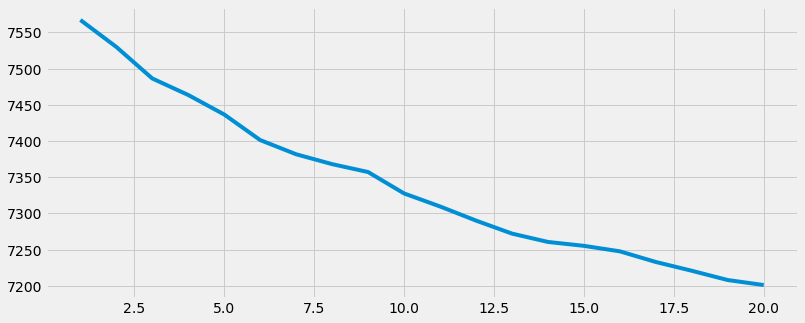

In [30]:
post_viral_intertia = kmeans_metrics(trump_tweets['ml_clean_text'][(trump_tweets['PostCampaignLaunchDummy']==1)& (trump_tweets['retweetDeciles']>7)],1000,1,20)

From tha above graph, we can see that the elbow for the most viral tweets in the post-political career period has no distinct kink to be declared as an 'elbow point'. A similar phenomena is observed for the remaining segments. Thus, perhaps inertia isn't the appropriate metric to judge our clusters by or perhaps kmens is not te ideal method of finding clusters for this data, both of which are possibiltes that shall be explored in the future. 

However, for now, the optimal number of clusters is chosen by examining if the clusters formed in the training data make sense and are sufficiently distinct (an approach that I would not reccomend).

The 10 most representative terms in each cluster are plotted to display how each cluster differs from the other and with different clusters appearing in each of the 4 segments, how each segment differs from the other.

In [15]:
def get_color_map(num_colors, color_scheme_name='Dark2'):
    '''
    Inputs:
    num_colors: number of distinct colors required
    color_scheme_name: standard matplotlib colormap name
    
    Output:
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color'''
    #source:
    return plt.cm.get_cmap(color_scheme_name, num_colors)

def plot_clusters(textToAnalyze,numTestObs,true_k,title):
    
    #INPUTS
    #textToAnalyze: the column to be analyzed
    #numTestObs: number of observations to old out for testing
    #true_k: number of hypothesised clusters
    #title: title of the graph
    
    
    from sklearn.cluster import KMeans
    
    cmap = get_color_map(true_k, 'Dark2')
    #cmap = get_cmap(len(range(true_k)), 'Dark2')
    
    #forming the clusters
    vectorizer = TfidfVectorizer(stop_words='english')
    x_vector = vectorizer.fit_transform(textToAnalyze[:-numTestObs].values)
    model = KMeans(n_clusters = true_k,init='k-means++', max_iter=100, n_init=1,random_state =0)
    model.fit(x_vector)
    
    #sorting each centroid in order of most important words in the cluster
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    #plotting centeroids as obtained in order of importances
    for i in range(true_k):
        order = 0
        clr = cmap(i)
        for ind in order_centroids[i, :10]:
            plt.scatter(i,order,s=0.01) 
            plt.text(i,order,terms[ind],ha='center',va='center_baseline',wrap=True,color=clr,fontname='Calibri', fontsize=20)
            order = order+1
    
    #formatting axis settings
    x_lables = [x for x in range(true_k)]
    y_lables = [y for y in range(order)]
    x_ticks = [f'Cluster {x}' for x in range(true_k)]
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.gca().set_xticks(x_lables)
    plt.gca().set_xticklabels(x_ticks)
    plt.gca().set_yticks(y_lables)
    plt.gca().set_yticklabels(y_lables)
    
    #formatting title settings
    plt.title(title,size = 30)
    plt.gca().title.set_position([.5, 1.1])
    #plt.tight_layout()

Having defined the function so , the kmeans based analysis is conducted.Note , for robust results, multiple values must be tried for the argument 'random_state' in KMeans. Furthermore, note that,  due to the meteoric rise of his polopularity post the launch of his campaign, the pre-political career retweets are in the lower deciles while the post-political career retweets are in the higher deciles. 

In the post-political career period, to have a clear distinction between the most viral and least viral tweets, the most viral tweets are defined as those that had retweet counts in the 8th or higher decile whie the least viral tweets are defined as those that had retweet counts in the 4th or lower deciles. 

In the pre-political career period, given that most tweets are in the lower deciles, to have a sufficently large corpus of tweets to cluster as the most viral, tweets having retweet counts in the 5th or higher deciles are chosen while for the least viral tweets , tweets having a retweet count in the 3rd or lower deciles are chosen.

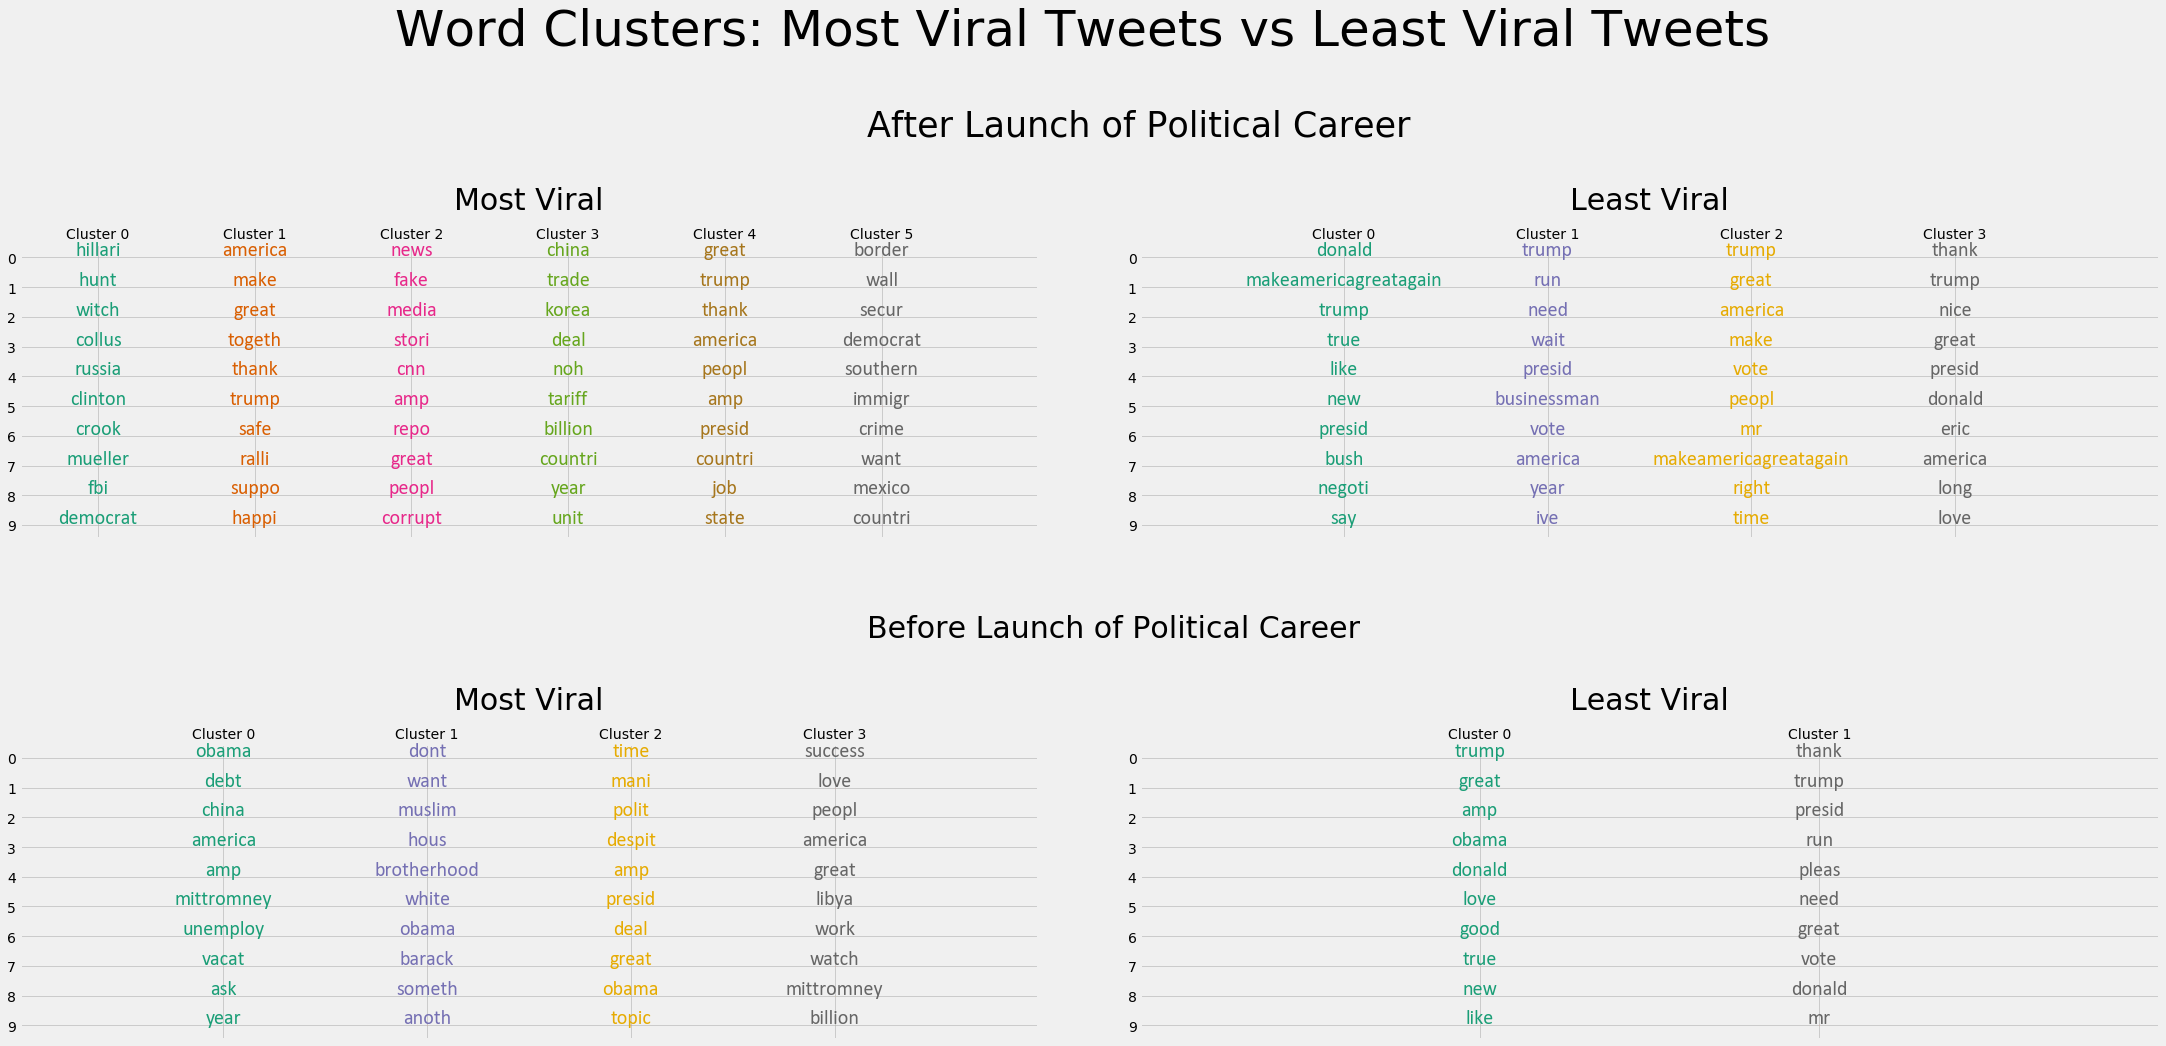

In [22]:
#fitting and plotting kmeans clusters
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,12))

#1. most viral since launch of political career
ax1 = fig.add_subplot(221)
plot_clusters(trump_tweets['ml_clean_text'][(trump_tweets['PostCampaignLaunchDummy']==1)& (trump_tweets['retweetDeciles']>7)],1000,6,'Most Viral')
ax1.set_xlim(-0.5, 6)

#2. least viral since launch of political career
ax2 = fig.add_subplot(222)
plot_clusters(trump_tweets['ml_clean_text'][(trump_tweets['PostCampaignLaunchDummy']==1)& (trump_tweets['retweetDeciles']<5)],1000,4,'Least Viral')
ax2.set_xlim(-1, 4)

#3. most viral before launch of political career
ax3 = fig.add_subplot(223) #3,4 try
plot_clusters(trump_tweets['ml_clean_text'][(trump_tweets['PostCampaignLaunchDummy']==0)&(trump_tweets['retweetDeciles']>4)],1000,4,'Most Viral') #5
ax3.set_xlim(-1, 4)

#4. least viral before launch of political career
ax4 = fig.add_subplot(224)
plot_clusters(trump_tweets['ml_clean_text'][(trump_tweets['PostCampaignLaunchDummy']==0)&(trump_tweets['retweetDeciles']<4)],1000,2,'Least Viral')
ax4.set_xlim(-1, 2)


fig.suptitle('Word Clusters: Most Viral Tweets vs Least Viral Tweets',size = 50,y = 1.2)
fig.text(0.4,1.05, 'After Launch of Political Career', fontsize=35)
fig.text(0.4,0.47, 'Before Launch of Political Career', fontsize=30)
fig.tight_layout(pad=0.3)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.7)

plt.show()

Let's consider the most viral and least viral clusters both before and after the launch of his political :  in both periods, his most viral tweets are the ones that are topically political and thus more divisive, while his least viral tweets have an over all more positive tone ('love','like' etc.) and are more akin to the genric content that most politicians tweet about i.e. their campaigns ('makeamericagreatagain','vote' etc.) and themselves/their families ('trump','donald','eric' etc.).

Comparing the most viral tweets in both periods,we see that prior to his election, the clusters generating the most retweets were rather singular - his viral tended to be centered around obama and his policies/ re-election. However, since the launch of his political career,the clusters generating the most retweets have become very distinct and encompass a variety of matters : cluster 0 refers to him allegedly colluding with Russia, cluster 2 is about fake news,cluster 3 is about the trade war and East Asia and cluster 5 is about the mexican border wall. Interestingly, post the lauch of his political career, only the viral tweets that center around america have any positive words associated with them (see cluster 1 and 4) - the other clusters either lack any positive languge or have overtly negative language associated with them ('crook' for cluster 0, 'fake and 'corrupt' for cluster 2, 'crime' for cluster 5).

Thus, we can clearly see from the above analysis that the more politically charged donald trumps tweets are, the more retweets he gets. This, in conjunction with the fact that his tweets have become notably more politically charged since the launch of his campaign , estabhish in a preliminary fashion that the rise in Donald trump's popularity can be explained by the increasinly ly politically charged nature of his tweets since the launch of his political career.

# So,can we predict how many retweets Trump will get based on the content of his tweets?

So, given that in the previous two sections a (fairly) clear relationship emerges between the content of Trump's tweets and the number of retweets - the more topical (/divisive) his tweet is, the larger the number of retweets he gets. So, lets exploit this relationship to build a model that can predict the number of retweets that trump will get based on the tweet composed by him. To do so, we use a Convolutional Neural Network (CNN).

#### 1. Defining vocabulary

In [15]:
vocab,total_words = vocabulary_counter(trump_tweets['ml_clean_text'])
    
# keep tokens with a min occurrence
min_occurane = 2 #3
filtered_tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(filtered_tokens))

filtered_tokens

# convert lines to a single blob of text
tokenBlob = '\n'.join(filtered_tokens)

# save tokens to a vocabulary file
with open('trumpTweetVocab.txt', "w", encoding="utf-8") as f:
    f.write(tokenBlob)
    # close file
    f.close()

13955


#### 2. splitting into training, validation and testing

In [16]:
test_percent = 0.20
no_test_obs =  int(np.round(test_percent*len(trump_tweets)))
training = trump_tweets[:-no_test_obs]
testing = trump_tweets[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.30
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

#### 3. Turn dependent variable 'retweet_count' into quintles

In [17]:
disc = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')
trainYml=training['retweet_count'].values
trainYml = disc.fit_transform(trainYml.reshape(-1,1)) #fit discretizer on training y
valYml = disc.transform(validation['retweet_count'].values.reshape(-1,1)) #transform validation y
osYml = disc.transform(outOfSample['retweet_count'].values.reshape(-1,1)) #transforn testing y

#### 4. Training the embedding layer

In [18]:
# a. reading in the created vocabulary 
vocab_filename = 'trumpTweetVocab.txt' # load  vocabulary
file = open(vocab_filename, 'r') # open file as read only
vocab = file.read() # read all text
file.close() # close file
vocab = vocab.split()
vocab = set(vocab)

#b. keeping only the words that occur in the vocabulary for each dataset
def keepVocab(text,vocabulary):
    t = 0
    for tweet in list(text.astype(str)):
        token = word_tokenize(tweet)
        vocabTokens = [w for w in token if w in vocabulary] # filter out tokens not in vocab
        text.iloc[t] = (' '.join(vocabTokens))
        t =  t+1
    return text

training['ml_clean_text'] = keepVocab(training['ml_clean_text'],vocab)
validation['ml_clean_text']= keepVocab(validation['ml_clean_text'],vocab)
outOfSample['ml_clean_text']= keepVocab(outOfSample['ml_clean_text'],vocab)

trainTweetArray = training['ml_clean_text'].values
valTweetArray = validation['ml_clean_text'].values
outOfSampleTweetArray = outOfSample['ml_clean_text'].values

#c. creating the tokenizer
tokenizer = Tokenizer()

#c.1 train and fit the tokenizer on the training tweets
tokenizer.fit_on_texts(trainTweetArray)

#c.2 encode the text into sequences
encoded_docs = tokenizer.texts_to_sequences(trainTweetArray)
encoded_val_docs = tokenizer.texts_to_sequences(valTweetArray)
encoded_os_docs = tokenizer.texts_to_sequences(outOfSampleTweetArray)

#c.3 pad sequences so that tweets have the same length.
max_length = max([len(s.split()) for s in list(training['ml_clean_text'].astype(str))])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xval = pad_sequences(encoded_val_docs, maxlen=max_length, padding='post')
Xos = pad_sequences(encoded_os_docs, maxlen=max_length, padding='post')

C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cafral\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Cafral\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide

#### 5. Create the fit the Neural Network

In [19]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 150, input_length=max_length))
model.add(Conv1D(filters=100, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=3, activation='linear'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh'))
#model.add(LSTM(200,activation = 'tanh'))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

EarlyStop = EarlyStopping(monitor='val_acc', patience=2, verbose=0, mode='auto')

epochs=100
# compile network ,batch_size = 10
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# fit network
model.fit(Xtrain, trainYml,epochs=epochs, callbacks= [EarlyStop] ,verbose=2, shuffle=False,validation_data =(Xval, valYml))

# evaluate
loss, acc = model.evaluate(Xos, osYml, verbose=0)
#print('Test Accuracy: %f' % (acc*100))
print(loss, acc)

Train on 35483 samples, validate on 6210 samples
Epoch 1/100
 - 31s - loss: 0.9516 - acc: 0.6013 - val_loss: 0.4462 - val_acc: 0.9023
Epoch 2/100
 - 31s - loss: 0.8943 - acc: 0.6135 - val_loss: 0.3692 - val_acc: 0.9011
Epoch 3/100
 - 30s - loss: 0.8254 - acc: 0.6441 - val_loss: 0.3654 - val_acc: 0.9014
0.4456609072333796 0.8733558812476513


#### 6. creating the confusion matrix

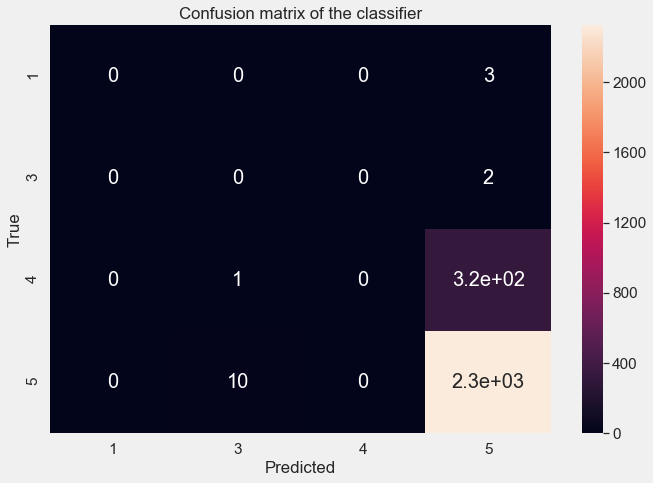

In [20]:
classPreds = model.predict_classes(Xos)

disc_ordinal = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
trainY_ordinal=training['retweet_count'].values
trainY_ordinal = disc_ordinal.fit_transform(trainY_ordinal.reshape(-1,1))
osY_ordinal = disc_ordinal.transform(outOfSample['retweet_count'].values.reshape(-1,1))


#creating the confusion matrix
cm = confusion_matrix(osY_ordinal,classPreds)

#plotting the confusion matrix
df_cm = pd.DataFrame(cm, range(4), range(4)) #creating a dataframe from the confusion matrix
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}) #plottting a heatmap
plt.title('Confusion matrix of the classifier')
x_lables = [1,3,4,5]
y_lables = [1,3,4,5]
plt.gca().set_xticklabels(x_lables)
plt.gca().set_yticklabels(y_lables)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the above analysis , we can see that in the testing period, there are not retweets in the second quantile. Importantly, we see that our classifier has a tendency to overclassify number of retweets as being in the 5th quantile.